In [123]:
#skysurvey/survey/lsst_comcam.py

import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt
from skysurvey.target import SNeIa, SNeII, SNeIIn, SNeIIb
from skysurvey.lightcurves import get_obsdata
import copy

def from_dp1_parquet(filepath, zp=30.0, exclude_yband=True, fov_arcmin=40.0):
    """
    Construct a skysurvey.Survey from a DP1 visit-level parquet file.

    Parameters
    ----------
    filepath : str
        Path to a `dp1_visits.parquet` file (or filtered version).
    zp : float
        Zeropoint to use in sky noise conversion (default: 30).
    exclude_yband : bool
        If True, excludes 'y' band visits.
    fov_arcmin : float
        Field of view in arcminutes (default: 40 for LSST ComCam).

    Returns
    -------
    survey : skysurvey.Survey
        Survey object usable with skysurvey.
    """
    df = pd.read_parquet(filepath)

    if exclude_yband:
        df = df[df["band"] != "y"]

    simdata = pd.DataFrame({
        "skynoise": df["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=zp).values,
        "mjd": df["mjd"].values,
        "band": "lsst" + df["band"].values,
        "gain": 1.0,
        "zp": zp,
        "ra": df["ra"].values,
        "dec": df["dec"].values
    }, index=df.index)

    # Construct square footprint (centered on 0,0 in local projection)
    fov_deg = fov_arcmin / 60.0
    half_size = fov_deg / 2.0
    footprint = box(-half_size, -half_size, half_size, half_size)

    return Survey.from_pointings(simdata, footprint=footprint)

def estimate_sn_population_from_parquet(
    parquet_path,
    zp=30.0,
    exclude_yband=True,
    fov_arcmin=40.0,
    zmin=0.0,
    zmax=0.2,
    include_effects=True,
):
    """
    Load a Survey from DP1 parquet and estimate SNeIa population given z-range and footprint.

    Parameters
    ----------
    parquet_path : str
        Path to visit-level parquet.
    zp : float
        Zeropoint for skynoise conversion.
    exclude_yband : bool
        Whether to exclude 'y' band observations.
    fov_arcmin : float
        Field of view size for footprint box.
    zmin, zmax : float
        Redshift bounds for population simulation.
    include_effects : bool
        Whether to apply mw_extinction.

    Returns
    -------
    snia : SNeIa target object
        The simulated population overlapping the footprint.
 
    snii : SNeII target object
    sniin : SNeIIn target object
    sniib : SNeIIb target object
    survey : Survey object

    survey : Survey object
        The loaded survey.
    """
    # Load survey from parquet
    survey = from_dp1_parquet(
        parquet_path,
        zp=zp,
        exclude_yband=exclude_yband,
        fov_arcmin=fov_arcmin,
    )

    # Reconstruct shapely.MultiPolygon skyarea from survey visit centers
    visit_df = pd.read_parquet(parquet_path)
    if exclude_yband:
        visit_df = visit_df[visit_df["band"] != "y"]

    fov_deg = fov_arcmin / 60.0
    half_fov = fov_deg / 2.0
    tiles = []
    for _, row in visit_df.iterrows():
        ra = row["ra"]
        dec = row["dec"]
        tile = box(ra - half_fov, dec - half_fov, ra + half_fov, dec + half_fov)
        tiles.append(tile)
    skyarea = unary_union(tiles)

    # Time range of the survey
    tstart, tstop = survey.get_timerange()

    # Build population with or without extinction
    effects = mw_extinction if include_effects else None
    
    snia = SNeIa.from_draw(
        tstart=tstart,
        tstop=tstop,
        skyarea=skyarea,
        zmin=zmin,
        zmax=zmax,
        effect=effects,
    )

    snii = SNeII.from_draw(
        tstart=tstart,
        tstop=tstop,
        skyarea=skyarea,
        zmin=zmin,
        zmax=zmax,
        effect=effects,
    )
    
    return snia, snii, survey



In [129]:
zmin=0.1
zmax=1.0

snia, snii, survey = estimate_sn_population_from_parquet(
    parquet_path,
    zmin=zmin,
    zmax=zmax,
)

  

print(f"Simulated {len(snia.data)} SNeIa between z = {zmin}-{zmax}")
print(f"Simulated {len(snii.data)} SNeII between z = {zmin}-{zmax}")


print(snia.data.head())


Simulated 48 SNeIa between z = 0.1-1.0
Simulated 111 SNeII between z = 0.1-1.0
         z     x1      c            t0         ra        dec     magabs  \
0  0.57315  0.670  0.097  60631.765625  59.674572 -48.422100 -18.958454   
1  0.28245  0.845  0.139  60624.492188  38.270454   6.600580 -19.070978   
2  0.69685  0.490 -0.044  60637.105469  37.884129   6.273479 -19.380344   
3  0.57795  1.030 -0.030  60631.945312  38.373291   6.727918 -19.486216   
4  0.43025  0.130  0.041  60627.269531  39.680416 -34.812199 -19.226547   

      mwebv     magobs        x0 template  
0  0.014774  23.724470  0.000005    salt2  
1  0.076374  21.802708  0.000030    salt2  
2  0.057047  23.817383  0.000005    salt2  
3  0.083177  23.218567  0.000008    salt2  
4  0.035879  22.711777  0.000013    salt2  


  Failed for SNeIa 0: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3146.3, .., 14473]
  Failed for SNeIa 2: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3393.7, .., 15611]


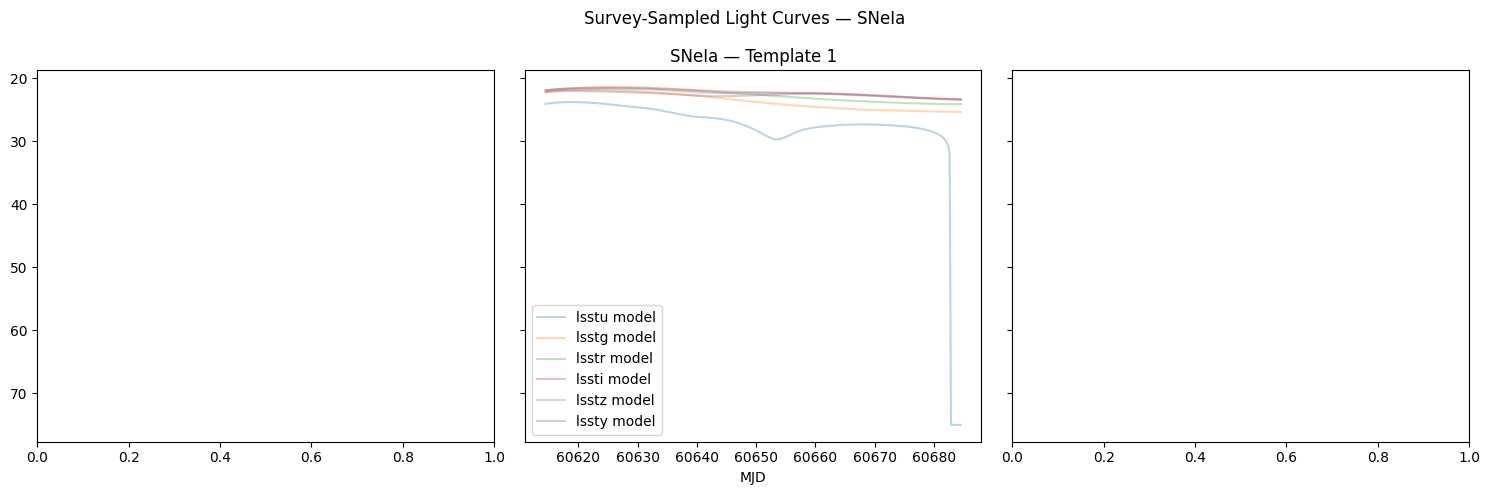

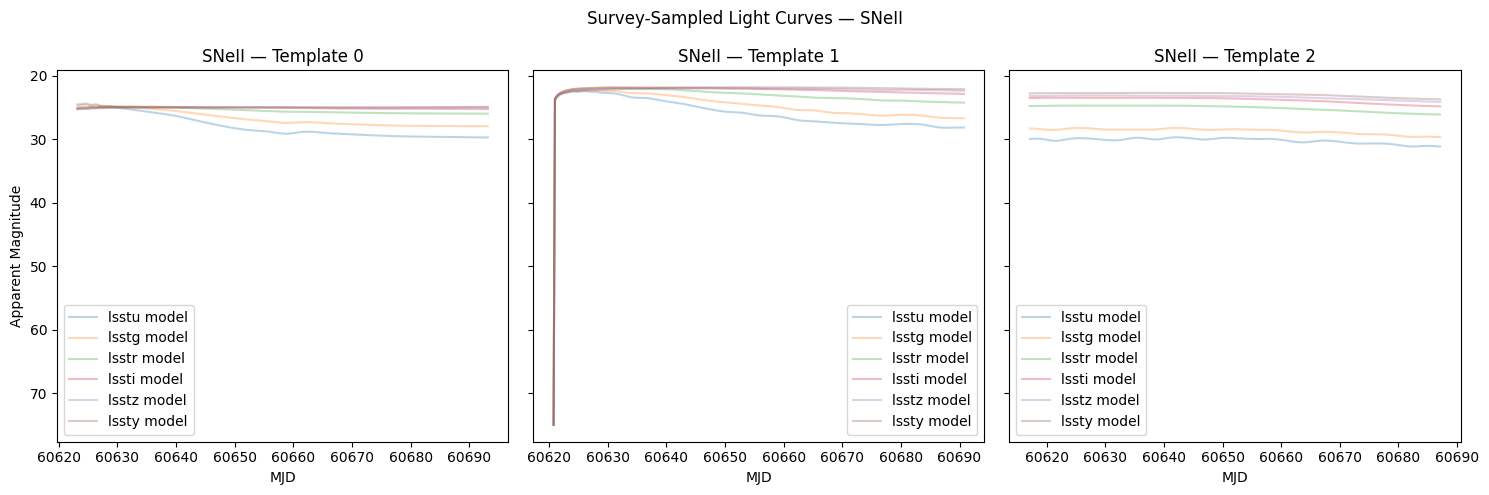

In [185]:
def plot_sampled_lightcurves(pop, survey, title=""):
    from sncosmo import Model

    sample_params = pop.data.iloc[:3]
    survey_obs = survey.data.copy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, (ix, params) in enumerate(sample_params.iterrows()):
        ax = axs[i]

        try:
            # ----------- Build model -------------
            if hasattr(pop.template, "sncosmo_model"):  # SNeIa
                base_model = pop.template.sncosmo_model
                model = Model(source=base_model.source)
            elif hasattr(pop.template, "get"):  # SNeII family
                model = pop.template.get(ix)
            else:
                raise ValueError("Unsupported template type")

            # Filter only valid model parameters
            valid_keys = model.param_names
            filtered_params = {k: v for k, v in params.items() if k in valid_keys}
            model.set(**filtered_params)

            # Use only filtered params for get_obsdata
            filtered_df = pd.DataFrame([filtered_params])

            # ----------- Get obsdata and plot -------------
            lc = get_obsdata(model, survey_obs, filtered_df)

            times = np.linspace(params["t0"] - 10, params["t0"] + 60, 300)
            for band in bands:
                try:
                    flux = model.bandflux(band, times, zp=25, zpsys="ab")
                    mag_model = -2.5 * np.log10(np.maximum(flux, 1e-20)) + 25
                    ax.plot(times, mag_model, label=f"{band} model", alpha=0.3)
                except Exception as e:
                    continue


            ax.set_title(f"{title} — Template {ix}")
            ax.set_xlabel("MJD")
            if i == 0:
                ax.set_ylabel("Apparent Magnitude")
            ax.invert_yaxis()
            ax.legend()

        except Exception as e:
            print(f"  Failed for {title} {ix}: {e}")
            continue

    plt.suptitle(f"Survey-Sampled Light Curves — {title}")
    plt.ylim(340
    plt.tight_layout()
    plt.show()

plot_sampled_lightcurves(snia, survey, title="SNeIa")
plot_sampled_lightcurves(snii, survey, title="SNeII")



  Skipping band lsstu for SNeIa 0: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3146.3, .., 14473]
  Skipping band lsstu for SNeIa 2: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3393.7, .., 15611]


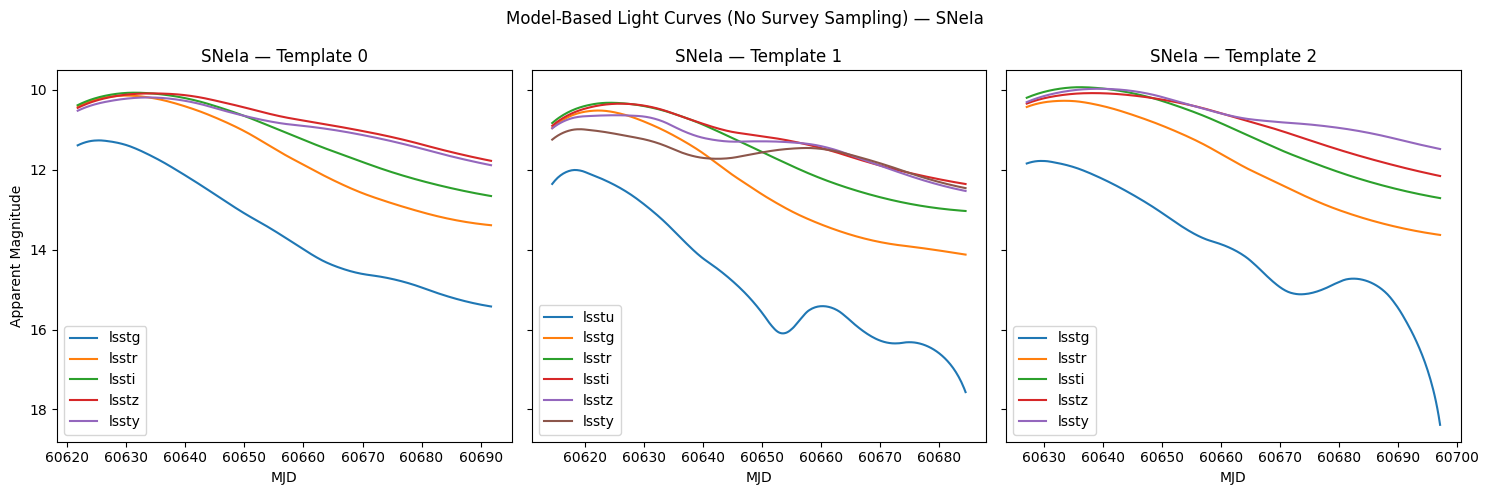

Processing SNeII...


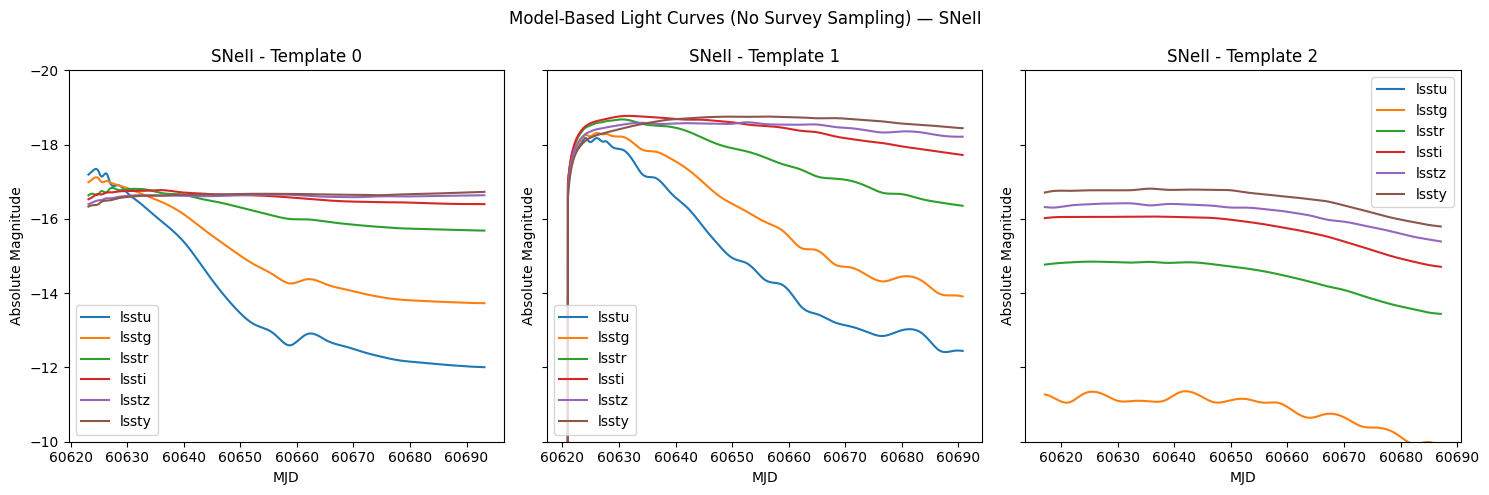

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import copy

bands = ["lsstu", "lsstg", "lsstr", "lssti", "lsstz", "lssty"]

#-----
#SneIa
#-----

# Get first 3 parameter sets
sample_params = snia.data.iloc[:3]

# Set up figure with 3 subplots (side by side)
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, (ix, params) in enumerate(sample_params.iterrows()):
    ax = axs[i]
    model = copy.copy(snia.template._sncosmo_model)
    model.set(z=params["z"], t0=params["t0"])

    times = np.linspace(params["t0"] - 10, params["t0"] + 60, 300)

    for band in bands:
        try:
            flux = model.bandflux(band, times, zp=25, zpsys="ab")
            mag = -2.5 * np.log10(np.maximum(flux, 1e-20)) + 25
            ax.plot(times, mag, label=band)
        except Exception as e:
            print(f"  Skipping band {band} for SNeIa {ix}: {e}")
            continue
            
    plt.suptitle(f"Model-Based Light Curves (No Survey Sampling) — SNeIa")
    ax.set_title(f"SNeIa — Template {ix}")
    ax.set_xlabel("MJD")
    if i == 0:
        ax.set_ylabel("Apparent Magnitude")
    ax.invert_yaxis()
    ax.legend()

plt.tight_layout()
plt.show()

populations = {
    "SNeII": snii,}

for name, pop in populations.items():
    print(f"Processing {name}...")

    try:
        sample_params = pop.data.iloc[:3]
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

        for col_idx, (ix, params) in enumerate(sample_params.iterrows()):
            ax = axs[col_idx]

            # Get the model (handle single-template or collection)
            if hasattr(pop.template, "get"):
                model = pop.template.get(ix)
            else:
                model = copy.copy(pop.template)

            t0 = params["t0"]
            z = params["z"]
            model.set(z=z, t0=t0)

            times = np.linspace(t0 - 10, t0 + 60, 300)

            for band in bands:
                try:
                    flux = model.bandflux(band, times, zp=25, zpsys="ab")
                    mag = -2.5 * np.log10(np.maximum(flux, 1e-20)) + 25
                    ax.plot(times, mag, label=band)
                except Exception as e:
                    print(f"  Skipping band {band}: {e}")
                    continue

            ax.set_title(f"{name} - Template {ix}")
            ax.set_xlabel("MJD")
            ax.set_ylabel("Absolute Magnitude")
            ax.invert_yaxis()
            ax.legend()

        plt.suptitle(f"Model-Based Light Curves (No Survey Sampling) — {name}")
        plt.ylim(-10,-20)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Skipping {name} due to error: {e}")
        continue



In [145]:
print(model.param_names)


['z', 't0', 'x0', 'x1', 'c']


  Failed for SNeIa 0: "Unknown parameter: 'ra'"
  Failed for SNeIa 1: "Unknown parameter: 'ra'"
  Failed for SNeIa 2: "Unknown parameter: 'ra'"


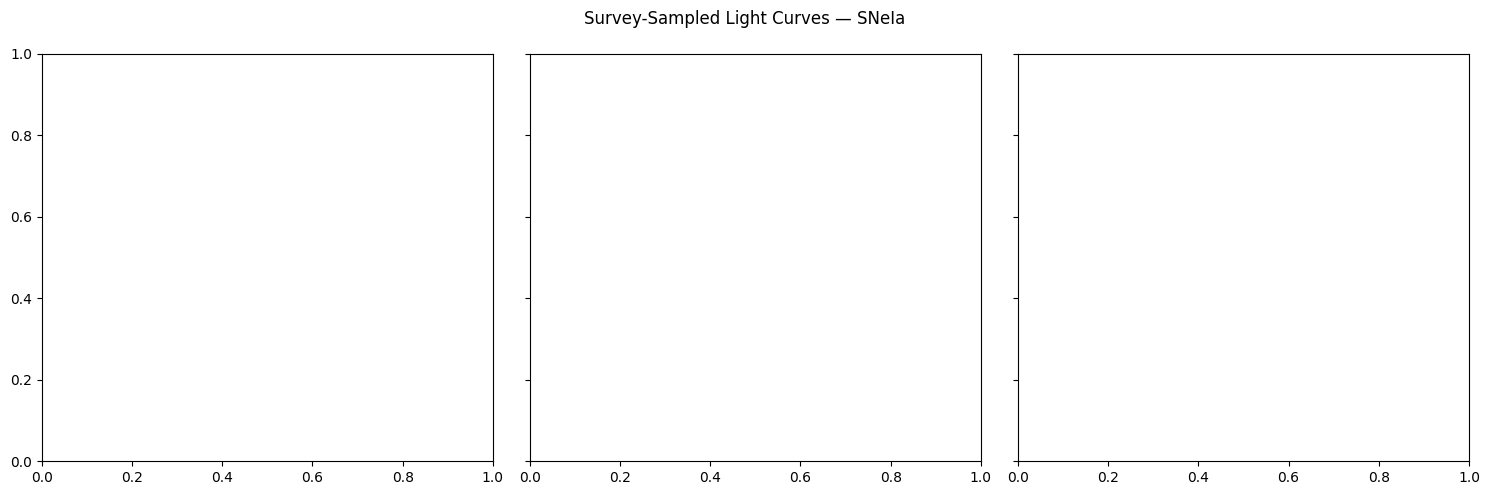

  Skipping band lsstu for SNeIa 0: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3146.3, .., 14473]
  Skipping band lsstg for SNeIa 0: "Unknown parameter: 'ra'"
  Skipping band lsstr for SNeIa 0: "Unknown parameter: 'ra'"
  Skipping band lssti for SNeIa 0: "Unknown parameter: 'ra'"
  Skipping band lsstz for SNeIa 0: "Unknown parameter: 'ra'"
  Skipping band lssty for SNeIa 0: "Unknown parameter: 'ra'"
  Skipping band lsstu for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lsstg for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lsstr for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lssti for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lsstz for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lssty for SNeIa 1: "Unknown parameter: 'ra'"
  Skipping band lsstu for SNeIa 2: bandpass 'lsstu' [3105, .., 4086] outside spectral range [3393.7, .., 15611]
  Skipping band lsstg for SNeIa 2: "Unknown parameter: 'ra'"
  Skipping band lsstr for SNeIa 2: "Unknown 

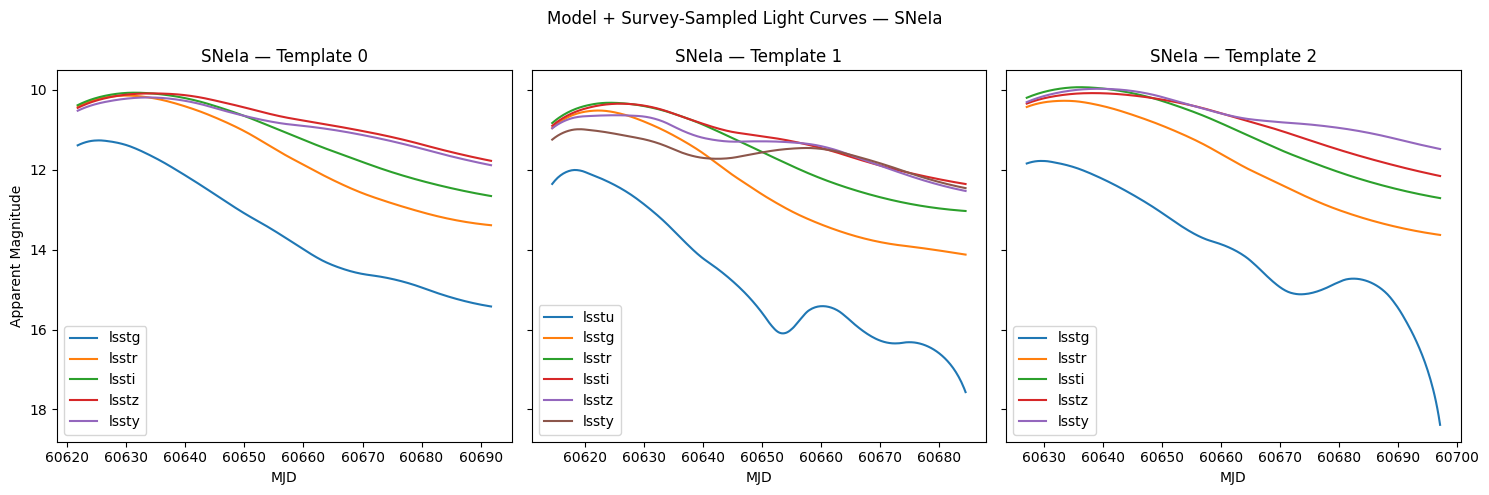

In [151]:
from sncosmo import Model
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# SNeIa (Survey Sampled)
# --------------------
sample_params = snia.data.iloc[:3]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, (ix, params) in enumerate(sample_params.iterrows()):
    ax = axs[i]

    try:
        # Create base model and set only valid parameters
        base_model = snia.template.sncosmo_model
        model = Model(source=base_model.source)
        valid_keys = model.param_names
        filtered_params = {k: v for k, v in params.items() if k in valid_keys}
        model.set(**filtered_params)

        # Generate synthetic observations
        lc = get_obsdata(model, survey_obs, params.to_frame().T)

        for band in bands:
            band_lc = lc[lc["band"] == band]
            if len(band_lc) == 0:
                continue

            mag = -2.5 * np.log10(np.maximum(band_lc["flux"], 1e-20)) + band_lc["zp"]
            mag_err = band_lc["fluxerr"] / band_lc["flux"] * 1.0857

            ax.errorbar(band_lc["mjd"], mag, yerr=mag_err, fmt="o", label=band)

        ax.set_title(f"SNeIa — Template {ix}")
        ax.set_xlabel("MJD")
        if i == 0:
            ax.set_ylabel("Apparent Magnitude")
        ax.invert_yaxis()
        ax.legend()

    except Exception as e:
        print(f"  Failed for SNeIa {ix}: {e}")

plt.suptitle("Survey-Sampled Light Curves — SNeIa")
plt.tight_layout()
plt.show()


# Get first 3 parameter sets
sample_params = snia.data.iloc[:3]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, (ix, params) in enumerate(sample_params.iterrows()):
    ax = axs[i]
    
    # Full model light curve
    model = copy.copy(snia.template._sncosmo_model)
    model.set(z=params["z"], t0=params["t0"])
    times = np.linspace(params["t0"] - 10, params["t0"] + 60, 300)

    for band in bands:
        try:
            # Plot full model
            flux = model.bandflux(band, times, zp=25, zpsys="ab")
            mag = -2.5 * np.log10(np.maximum(flux, 1e-20)) + 25
            ax.plot(times, mag, label=band, lw=1.5)

            # Plot survey-sampled data
            obs_model = sncosmo.Model(source=model.source)
            obs_model.set(z=params["z"], t0=params["t0"])
            lc = get_obsdata(obs_model, survey_obs, params.to_frame().T)
            band_lc = lc[lc["band"] == band]
            if len(band_lc) > 0:
                mag_obs = -2.5 * np.log10(np.maximum(band_lc["flux"], 1e-20)) + band_lc["zp"]
                mag_err = band_lc["fluxerr"] / band_lc["flux"] * 1.0857
                ax.errorbar(band_lc["mjd"], mag_obs, yerr=mag_err, fmt='o', ms=4)

        except Exception as e:
            print(f"  Skipping band {band} for SNeIa {ix}: {e}")
            continue

    ax.set_title(f"SNeIa — Template {ix}")
    ax.set_xlabel("MJD")
    if i == 0:
        ax.set_ylabel("Apparent Magnitude")
    ax.invert_yaxis()
    ax.legend()

plt.suptitle("Model + Survey-Sampled Light Curves — SNeIa")
plt.tight_layout()
plt.show()



       skynoise           mjd   band  gain    zp         ra        dec  \
1369  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   
1376  41.121597  60623.257812  lssti   1.0  30.0  53.327236 -28.072054   
1880  41.121597  60623.257812  lssti   1.0  30.0  53.327236 -28.072054   
1881  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   
2987  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   

      fieldid_survey  fieldid  
1369               1   351881  
1376               0   351881  
1880               0   352681  
1881               1   352681  
2987               1   352682  
[60623.2578125 60655.28125  ]


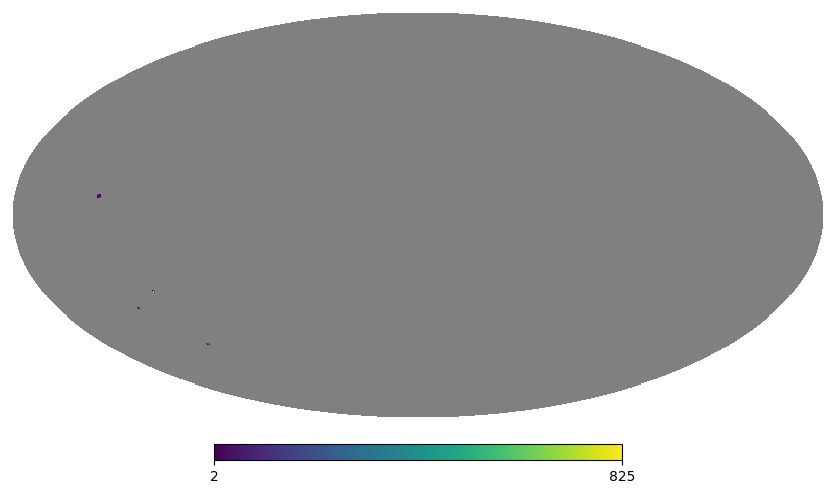

In [125]:
# Load the DP1 visit-level Parquet file

parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"  # or your path

# Run and inspect the survey
survey = from_dp1_parquet(parquet_path)

# Show some properties
np.NaN = np.nan  # TEMP FIX for skysurvey compatibility with NumPy 2.0
print(survey)
print(survey.data.head())
print(survey.get_timerange())
survey.show()



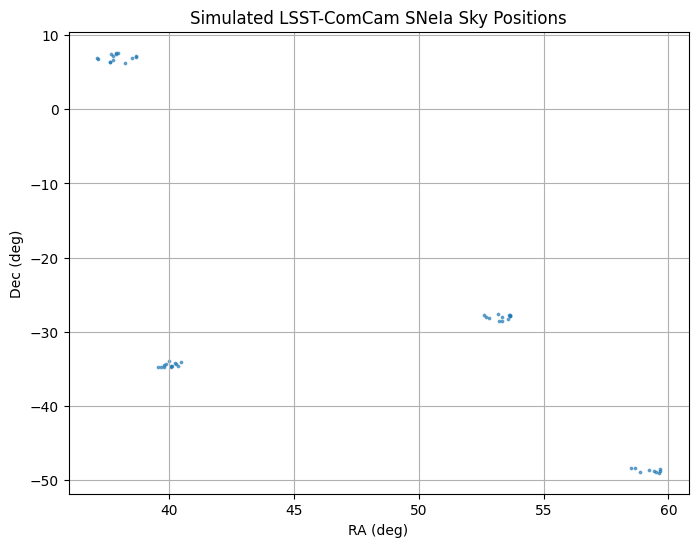

In [99]:

plt.figure(figsize=(8, 6))
plt.scatter(snia.data["ra"], snia.data["dec"], s=3, alpha=0.6)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Simulated LSST-ComCam SNeIa Sky Positions")
plt.grid(True)
plt.show()
